## 03) 영어/한국어 Word2Vec 실습

이번 챕터에서는 영어와 한국어 훈련 데이터에 대해서 Word2Vec을 학습해보겠다. gensim 패키지에서 Word2Vec은 이미 구현되어져 있으므로, 별도로 Word2Vec을 구현할 필요없이 손쉽게 훈련시킬 수 있다.

### 1.영어 Word2Vec 만들기

이번에는 영어 데이터를 다운로드 받아 직접 Word2Vec 작업을 진행해보도록 하겠다. 파이썬의 gensim 패키지에는 Word2Vec을 지원하고 있어, gensim 패키지를 이용하면 손쉽게 단어를 임베딩 벡터로 변환시킬 수 있다. 영어로 된 코퍼스를 다운받아 전처리를 수행하고, 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행하겠다.

우선 필요한 도구들을 임포트한다.


In [50]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

#### 1) 훈련 데이터 이해하기

파이썬 코드를 통해 훈련 데이터를 다운로드 한다.

In [52]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml",
                           filename="ted_en-20160408.xml")


('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f92601dff10>)

In [53]:
ls

cirrus-extract.py  extract.py                            ted_en-20160408.xml
clean.py           __init__.py                           WikiExtractor.py
extractPage.py     kowiki-latest-pages-articles.xml.bz2


훈련 데이터 파일은 xml 문법으로 작성되어 있어 자연어를 얻기 위해서는 전처리가 필요하다. 얻고자 하는 실질적 데이터는 영어문장으로만 구성된 내용을 담고 있는 <(content)>와 <(/content)> 사이의 내용이다. 전처리 작업을 통해 xml 문법들은 제거하고, 해당 데이터만 가져와야 한다. 뿐만 아니라, <(content)>와 <(/content)> 사이의 내용 중에는 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어도 등장하는데 이 또한 제거해야 한다.

``` xml
<file id="1">
  <head>
<url>http://www.ted.com/talks/knut_haanaes_two_reasons_companies_fail_and_how_to_avoid_them</url>
       <pagesize>72832</pagesize>
... xml 문법 중략 ...
<content>
Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities:
... content 내용 중략 ...
To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.
(Laughter)
... content 내용 중략 ...
(Applause)
</content>
</file>
<file id="2">
    <head>
<url>http://www.ted.com/talks/lisa_nip_how_humans_could_evolve_to_survive_in_space<url>
... 이하 중략 ...
```


#### 2) 훈련 데이터 전처리하기

위 데이터를 위한 전처리 코드는 아래와 같다.

In [54]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]


In [55]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


총 샘플의 개수는 약 27만 3천개이다.

In [56]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


상위 문장 3개만 출력해보았는데 토큰화가 수행되었음을 볼 수 있다. 이제 Word2Vec 모델에 텍스트 데이터를 훈련시킨다.

#### 3) Word2Vec 훈련시키기



In [57]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = result, size = 100, window = 5,
                 min_count = 5, workers = 4, sg = 0)

여기서 Word2Vec의 하이퍼파라미터값은 다음과 같다.

* **size** = 워드 벡터의 특징 값. 즉, 임베딩된 벡터의 차원.
* **window** = 컨텍스트 윈도우 크기
* **min_count** = 단어 최소 빈도 수 제한(빈도가 적은 단어들은 학습하지 않는다.)
* **workers** = 학습을 위한 프로세스 수
* **sg** = 0은 CBOW, 1은 Skip-gram

이제 Word2Vec에 대해서 학습을 진행하였다. Word2Vec은 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원한다. man과 가장 유사한 단어들은 어떤 단어들일까?


In [58]:
model_result = model.wv.most_similar('man')
model_result

[('woman', 0.8437852263450623),
 ('guy', 0.8156658411026001),
 ('lady', 0.7765352129936218),
 ('boy', 0.7667440176010132),
 ('girl', 0.7438370585441589),
 ('gentleman', 0.7196440100669861),
 ('soldier', 0.7157543301582336),
 ('poet', 0.6799652576446533),
 ('king', 0.6745074391365051),
 ('kid', 0.665330708026886)]

man과 유사한 단어로 woman, guy, boy, lady, girl, gentleman, soldier, kid 등을 출력하는 것을 볼 수 있다. 이제 Word2Vec을 통해 단어의 유사도를 계산할 수 있게 되었다.
 

#### 4) Word2Vec 모델 저장하고 로드하기

공들여 학습한 모델을 언제든 나중에 다시 사용할 수 있도록 컴퓨터 파일로 저장하고 다시 로드해보겠다. 이 모델을 가지고 시각화 챕터에서 시각화를 진행할 예정이므로 꼭 저장하자.



In [59]:
# Google Drive Mount
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
cd '/content/drive/My Drive/02. 데이터'

/content/drive/My Drive/02. 데이터


In [61]:
from gensim.models import KeyedVectors

model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v') # 모델 로드

In [62]:
ls

 _about.txt                             model.png
'강우예측AI 데이터'/                    ner_dataset.csv
 best_model.h5                          pr_report.html
 eng_w2v                                ratings.txt
 fra-eng.zip                            spam.csv
 fra.txt                                train.txt
'폭격의 날개왕(통합).gdoc'             '폭격의 날개왕(통합).txt'
 IWSLT16.TED.tst2011.en-cs.en.xml       wikiextractor/
 kowiki-latest-pages-articles.xml.bz2


로드한 모델에 대해서 다시 man과 유사한 단어를 출력해보겠다.

In [63]:
model_result = loaded_model.most_similar('man')
model_result

[('woman', 0.8437852263450623),
 ('guy', 0.8156658411026001),
 ('lady', 0.7765352129936218),
 ('boy', 0.7667440176010132),
 ('girl', 0.7438370585441589),
 ('gentleman', 0.7196440100669861),
 ('soldier', 0.7157543301582336),
 ('poet', 0.6799652576446533),
 ('king', 0.6745074391365051),
 ('kid', 0.665330708026886)]

### 2.한국어 Word2Vec 만들기(네이버 영화 리뷰)



In [64]:
# konlpy install
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [65]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt",
                           filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f9239bbf950>)

In [66]:
ls

 _about.txt                             model.png
'강우예측AI 데이터'/                    ner_dataset.csv
 best_model.h5                          pr_report.html
 eng_w2v                                ratings.txt
 fra-eng.zip                            spam.csv
 fra.txt                                train.txt
'폭격의 날개왕(통합).gdoc'             '폭격의 날개왕(통합).txt'
 IWSLT16.TED.tst2011.en-cs.en.xml       wikiextractor/
 kowiki-latest-pages-articles.xml.bz2


In [67]:
train_data = pd.read_table('ratings.txt')

In [68]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [69]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [70]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [71]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [72]:
print(len(train_data)) # 다시 리뷰 개수 출력

199992


In [73]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


In [74]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [75]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [28]:
# 형태소 분석기 Okt를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem = True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


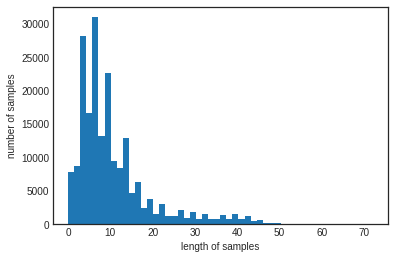

In [29]:
plt.style.use(['seaborn-white'])

# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :', max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :', sum(map(len, tokenized_data)) / len(tokenized_data))

plt.hist([len(s) for s in tokenized_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5,
                 min_count = 5, workers = 4, sg = 0)

In [31]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [32]:
print(model.wv.most_similar('최민식'))

[('한석규', 0.8809595108032227), ('이정재', 0.8696367740631104), ('박중훈', 0.8584884405136108), ('최민수', 0.8555097579956055), ('안성기', 0.8404949903488159), ('김갑수', 0.8329737186431885), ('이민호', 0.8299698233604431), ('류덕환', 0.8299298286437988), ('송강호', 0.8293135166168213), ('설경구', 0.8283264636993408)]


In [33]:
print(model.wv.most_similar('히어로'))

[('느와르', 0.8688098788261414), ('무협', 0.8670737743377686), ('슬래셔', 0.8659976720809937), ('호러', 0.8524283170700073), ('물의', 0.8372771143913269), ('무비', 0.8267295360565186), ('헐리우드', 0.825741708278656), ('블록버스터', 0.8204020261764526), ('멜로', 0.8176702260971069), ('정통', 0.816220760345459)]


### 3.한국어 Word2Vec 만들기(위키피디아)

이번에는 위키피디아 한국어 덤프 파일을 다운받아서 한국어로 Word2Vec을 직접 진행해보겠다. 영어와 크게 다른 점은 없지만 한국어는 형태소 토큰화를 해야만 좋은 성능을 얻을 수 있다. 간단히 말해 형태소 분석기를 사용한다.

#### 1) 위키피디아 한국어 덤프 파일 다운로드

https://dumps.wikimedia.org/kowiki/latest/

<img src = 'https://wikidocs.net/images/page/22660/bz2.PNG' width = 60%>

위 링크에는 많은 위키피디아 덤프 파일들이 존재한다. 그 중에서 사용할 데이터는 kowiki-latest-pages-articles.xml.bz2 파일이다. 해당 파일은 xml 파일이므로, Word2Vec을 원활하게 진행하기 위해 파일 형식을 변환해줄 필요가 있다.

#### 2) 위키피디아 익스트랙터 다운로드

해당 파일을 모두 다운로드 받았다면 위키피디아 덤프 파일을 텍스트 형식으로 변환시켜주는 오픈소스인 '위키피디아 익스트랙터'를 사용할 것이다. '위키피디아 익스트랙터'를 다운로드 받기 위해서는 윈도우의 명령 프롬프트나 MAC과 리눅스의 터미널에서 아래의 git clone 명령어를 통해 다운로드 받을 수 있다.

In [34]:
!git clone "https://github.com/attardi/wikiextractor.git"  

fatal: destination path 'wikiextractor' already exists and is not an empty directory.


In [76]:
ls

 _about.txt                             model.png
'강우예측AI 데이터'/                    ner_dataset.csv
 best_model.h5                          pr_report.html
 eng_w2v                                ratings.txt
 fra-eng.zip                            spam.csv
 fra.txt                                train.txt
'폭격의 날개왕(통합).gdoc'             '폭격의 날개왕(통합).txt'
 IWSLT16.TED.tst2011.en-cs.en.xml       wikiextractor/
 kowiki-latest-pages-articles.xml.bz2


#### 3) 위키피디아 한국어 덤프 파일 변환

위키피디아 익스트랙터와 위키피디아 한국어 덤프 파일을 동일한 디렉터리 경로에 두고, 아래 명령어를 실행하면 위키피디아 덤프 파일이 텍스트 파일로 변환된다. 컴퓨터마다 다르지만 보통 10분 내외의 시간이 걸린다.

In [47]:
!git clone "https://github.com/attardi/wikiextractor.git"

Cloning into 'wikiextractor'...
remote: Enumerating objects: 733, done.
remote: Total 733 (delta 0), reused 0 (delta 0), pack-reused 733
Receiving objects: 100% (733/733), 1.28 MiB | 5.37 MiB/s, done.
Resolving deltas: 100% (427/427), done.


cirrus-extract.py  extract.py                            wikiextractor/
clean.py           __init__.py                           WikiExtractor.py
extractPage.py     kowiki-latest-pages-articles.xml.bz2


In [77]:
!python WikiExtractor.py kowiki-latest-pages-articles.xml.bz2

python3: can't open file 'WikiExtractor.py': [Errno 2] No such file or directory


In [ ]:
cat WikiExtractor.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-

# =============================================================================
#  Version: 3.0 (July 22, 2020)
#  Author: Giuseppe Attardi (attardi@di.unipi.it), University of Pisa
#
#  Contributors:
#   Antonio Fuschetto (fuschett@aol.com)
#   Leonardo Souza (lsouza@amtera.com.br)
#   Juan Manuel Caicedo (juan@cavorite.com)
#   Humberto Pereira (begini@gmail.com)
#   Siegfried-A. Gevatter (siegfried@gevatter.com)
#   Pedro Assis (pedroh2306@gmail.com)
#   Wim Muskee (wimmuskee@gmail.com)
#   Radics Geza (radicsge@gmail.com)
#   Nick Ulven (nulven@github)
#
# =============================================================================
#  Copyright (c) 2009-2020. Giuseppe Attardi (attardi@di.unipi.it).
# =============================================================================
#  This file is part of Tanl.
#
#  Tanl is free software; you can redistribute it and/or modify it
#  under the terms of the GNU Affero General Public License, 

텍스트 파일로 변환된 위키피디아 한국어 덤프는 총 6개의 디렉토리(2018년 10월 기준)로 구성되어져 있다. AA ~ AF의 디렉토리로 각 디렉토리 내에는 wiki_00 ~ wiki_90이라는 파일들이 들어있다. 각 파일들을 열어보면 이와 같은 구성이 반복되고 있다.

```
<doc id="문서 번호" url="실제 위키피디아 문서 주소" title="문서 제목">
내용
</doc>
```

예를 들어서 AA 디렉토리의 wiki_00 파일을 읽어보면, 지미 카터에 대한 내용이 나온다.

```
<doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">
지미 카터
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령(1977년 ~ 1981년)이다.
지미 카터는 조지아 주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대
위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다.
... 이하 중략...
</doc>
```

이제 이 6개 AA ~ AF 디렉토리 안의 wiki_00 ~ wiki_90 파일들을 하나의 텍스트 파일로 통합하겠다. (만약, 더 간단히 하고 싶다면 모든 디렉토리 파일을 통합하지 않고, 하나의 디렉토리 내의 파일들에 대해서만 통합 작업을 진행하고 모델의 입력으로 사용할 수도 있다. 하지만 모델의 성능은 전체 파일에 대해서 진행한 경우보다 좋지 않을 수 있다.)

작업은 6개의 디렉토리 내 파일들에 대해서 각 하나의 파일로 통합 후, 6개의 파일을 다시 하나로 통합하는 순서로 진행한다.



#### 4) 훈련 데이터 만들기

우선 AA 디렉토리 안의 모든 파일인 wiki00 ~ wiki90에 대해서 wikiAA.txt로 통합해보겠다. 프롬프트에서 아래의 커맨드를 수행한다. (윈도우 환경 기준)

```
copy AA디렉토리의 경로\wiki* wikiAA.txt
```

해당 커맨드는 AA디렉토리 안의 wiki로 시작되는 모든 파일을 wikiAA.txt 파일에 전부 복사하라는 의미를 담고 있다. 결과적으로 wiki00 ~ wiki90파일의 모든 내용은 wikiAA.txt 파일이라는 하나의 파일에 내용이 들어가게 된다.

각 디렉토리에 대해서도 동일하게 진행한다.

```
copy AB디렉토리의 경로\wiki* wikiAB.txt
copy AC디렉토리의 경로\wiki* wikiAC.txt
copy AD디렉토리의 경로\wiki* wikiAD.txt
copy AE디렉토리의 경로\wiki* wikiAE.txt
copy AF디렉토리의 경로\wiki* wikiAF.txt
```

이렇게 되면 현재 경로에는 각 디렉토리의 파일들을 하나로 합친 wikiAA.txt 부터 wikiAF.txt 라는 6개의 파일이 생긴다. 그럼 이제 이 파일들에 대해서도 하나의 파일로 합치는 작업을 진행해보겠다.

```
copy 현재 디렉토리의 경로\wikiA* wiki_data.txt
```

이제 모든 텍스트 파일을 하나로 만든 훈련 데이터가 완성되었다.


